# Imports

In [1]:
# Python ≥3.5
import sys
assert sys.version_info >= (3, 5)

import numpy as np
import os
import seaborn as sns
import pandas as pd
import datetime as dt
from sklearn_pandas import DataFrameMapper

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from mpl_toolkits.mplot3d import Axes3D
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Scikit-Learn ≥0.20
import sklearn
assert sklearn.__version__ >= "0.20"


from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
from zlib import crc32
import hashlib
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from six.moves import urllib
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import (TimeSeriesSplit, KFold, ShuffleSplit,
StratifiedKFold, GroupShuffleSplit,
GroupKFold, StratifiedShuffleSplit,cross_val_score)
from sklearn.linear_model import Ridge
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import (StandardScaler, PolynomialFeatures)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (OrdinalEncoder,OneHotEncoder)
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')
from ta.utils import dropna
from ta.volatility import BollingerBands
from ta import add_all_ta_features
import numpy as np
import pandas as pd
from sklearn.ensemble import *
import xgboost as xgb
import operator

import settings
from ta import *
import utils

import datetime, pytz
#define a conversion function for the native timestamps in the csv file
def dateparse (time_in_secs):    
    return pytz.utc.localize(datetime.datetime.fromtimestamp(float(time_in_secs)))

# Donde guardar las figuras
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Auxiliar functions

In [2]:
def correlationMatrix(data_corr, fig_size=(17, 12)):
    # Correlation matrix of the resultant attributes
    corr_matrix_pr = data_corr.corr()
    paleta = sns.diverging_palette(150, 275, s=80, l=40, n=20)
    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=fig_size)
        ax = sns.heatmap(corr_matrix_pr,
                         annot=True,
                         annot_kws={'size': 13},
                         fmt='.2f',
                         vmax=1, 
                         vmin=-1, 
                         square=True, 
                         linewidths=.01, 
                         linecolor='lightgray', 
                         cmap=paleta)
def addPreviousClose(df):
    df['Close_previous'] = df['Close'].shift(-1)
    return df
def addTargetFeature(df):
    df["Target"] = 0 # 'KEEP'
    df.loc[df.Close + (df.Close * settings.PERCENT_UP) < df.Close_previous, "Target"] = 1 # 'UP'
    df.loc[df.Close - (df.Close * settings.PERCENT_DOWN) > df.Close_previous, "Target"] = 2 # 'DOWN'
    return df
def addDateFeatures(df):
    df['Date'] = pd.to_datetime(df.index)
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Week'] = df['Date'].dt.weekofyear
    df['Weekday'] = df['Date'].dt.weekday
    df['Day'] = df['Date'].dt.day
    df['Hour'] = df['Date'].dt.hour
    return df

def scaleDataFrame(df):
    features = ['Close_previous', 'Close', 'Volume_BTC', 'Volume_USD',
           'volume_adi', 'volume_cmf', 'volume_fi', 'volume_vpt', 'volume_vwap',
           'volatility_kcw', 'volatility_kchi', 'volatility_ui', 'trend_sma_slow',
           'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_b', 'trend_adx',
           'momentum_stoch_signal', 'others_dr']

    mapper = DataFrameMapper([(features, StandardScaler())])
    scaled_features = mapper.fit_transform(df.copy(), len(features))
    scaled_df = pd.DataFrame(scaled_features, index=df.index, columns=features)

    scaled_df['Target'] = df['Target'] 
    scaled_df['Year'] = df['Year']
    scaled_df['Month'] = df['Month']
    scaled_df['Week'] = df['Week']
    scaled_df['Weekday'] = df['Weekday']
    scaled_df['Day'] = df['Day']
    scaled_df['Hour'] = df['Hour']
    return scaled_df

def addAllFeaturesWithoutNan(df):
    df = add_all_ta_features(
        df, open="Open", high="High", low="Low", close="Close", volume="Volume_BTC")
    df_snan=df[relevant_att].interpolate(method='polynomial', order=3)
    df_snan = df_snan.dropna()
    df_snan['Date'] = df['Date']
    df_snan['Hour'] = df['Hour']
    df_snan['Day'] = df['Day']
    df_snan['Week'] = df['Week']
    df_snan['Weekday'] = df['Weekday']
    df_snan['Month'] = df['Month']
    df_snan['Close_previous'] = df['Close_previous']
    df_snan['Target'] = df['Target']
    df_snan['Year'] = df['Year']
    return df_snan

# Load dataset

In [3]:
bitcoin_hist = pd.read_csv("data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv",
                 parse_dates=[0],
                 date_parser=dateparse)
bitcoin_hist.rename(columns={'Volume_(BTC)':'Volume_BTC','Volume_(Currency)':'Volume_USD'}, inplace=True)

We keep the dataset information from Sunday, 7 July 2019 0:00:00 to Tuesday, 30 March 2021 0:00:00

In [4]:
start = bitcoin_hist.Timestamp.searchsorted(dateparse(1562457600))
end = bitcoin_hist.Timestamp.searchsorted(dateparse(1617062400))
bitcoin_hist = bitcoin_hist[start:end]
bitcoin_hist.count()

Timestamp         910080
Open              897858
High              897858
Low               897858
Close             897858
Volume_BTC        897858
Volume_USD        897858
Weighted_Price    897858
dtype: int64

Analyzing the correlation between the initial dataset attributes.

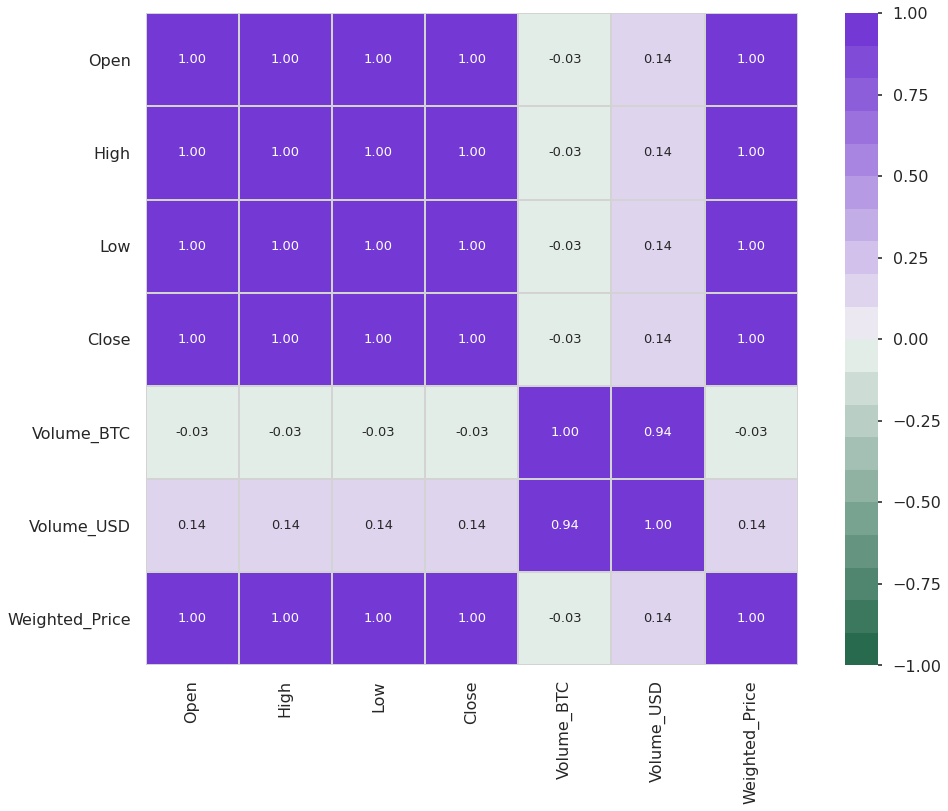

In [5]:
df = bitcoin_hist.sample(frac= 0.001)
correlationMatrix(df)

# Clean dataset

In [6]:
# amount of nan in the dataset
bitcoin_hist[bitcoin_hist.isna().any(axis=1)]

,Timestamp,Open,High,Low,Close,Volume_BTC,Volume_USD,Weighted_Price
3945941,2019-07-06 22:25:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3945988,2019-07-06 23:12:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3946271,2019-07-07 03:55:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3946299,2019-07-07 04:23:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3946315,2019-07-07 04:39:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
4854360,2021-03-28 18:44:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4854499,2021-03-28 21:03:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4854599,2021-03-28 22:43:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4854673,2021-03-28 23:57:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Filling the NaNs values with a polynomial interpolation of degree 3.

In [7]:
bitcoin=bitcoin_hist[['Open', 'High', 'Low', 'Close', 'Volume_BTC', 'Volume_USD',
       'Weighted_Price']].interpolate(method='polynomial', order=3)
bitcoin['Timestamp'] = bitcoin_hist.Timestamp

In [8]:
# amount of nan in the dataset
bitcoin[bitcoin.isna().any(axis=1)]

,Open,High,Low,Close,Volume_BTC,Volume_USD,Weighted_Price,Timestamp


# Stationarity check 
- Trend: The increasing or decreasing value in the series.
- Seasonality: The repeating short-term cycle in the series.
- Noise: The random variation in the series.

In [9]:
# Unix-time to 
bitcoin.Timestamp = pd.to_datetime(bitcoin.Timestamp, unit='s')

bitcoin.index = bitcoin.Timestamp
df_week = bitcoin.resample('W').mean()
df_week = df_week.dropna().copy()


# Resampling to daily frequency
df_day = bitcoin.resample('D').mean()
df_day = df_day.dropna().copy()

# Resampling to monthly frequency
df_month = bitcoin.resample('M').mean()
df_month = df_month.dropna().copy()

# Resampling to annual frequency
df_year = bitcoin.resample('A-DEC').mean()
df_year = df_year.dropna().copy()

# Resampling to quarterly frequency
df_Q = bitcoin.resample('Q-DEC').mean()
df_Q = df_Q.dropna().copy()

In [14]:
bitcoin

,Open,High,Low,Close,Volume_BTC,Volume_USD,Weighted_Price,Timestamp
Timestamp,,,,,,,,
2019-07-06 21:00:00+00:00,11233.21,11233.23,11189.96,11196.66,9.558404,107253.516330,11220.860208,2019-07-06 21:00:00+00:00
2019-07-06 21:01:00+00:00,11185.00,11185.00,11097.76,11097.76,20.164677,224737.213490,11145.093844,2019-07-06 21:01:00+00:00
2019-07-06 21:02:00+00:00,11095.00,11129.25,11087.45,11129.25,27.553246,305955.457460,11104.153045,2019-07-06 21:02:00+00:00
2019-07-06 21:03:00+00:00,11143.48,11146.54,11134.22,11134.53,3.977329,44311.680104,11141.063731,2019-07-06 21:03:00+00:00
2019-07-06 21:04:00+00:00,11134.53,11134.53,11107.46,11118.11,2.362724,26258.410936,11113.617372,2019-07-06 21:04:00+00:00
...,...,...,...,...,...,...,...,...
2021-03-29 20:55:00+00:00,57652.44,57668.22,57620.86,57633.76,0.858080,49458.224417,57638.261471,2021-03-29 20:55:00+00:00
2021-03-29 20:56:00+00:00,57655.21,57655.21,57631.89,57631.89,0.403548,23257.330868,57632.185872,2021-03-29 20:56:00+00:00
2021-03-29 20:57:00+00:00,57652.50,57652.50,57610.63,57614.63,0.133400,7689.124556,57639.614361,2021-03-29 20:57:00+00:00


### Weekly

In [10]:
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_week.Weighted_Price).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_week.Weighted_Price)[1])
plt.show()

ValueError: x must have 2 complete cycles requires 104 observations. x only has 92 observation(s)

<Figure size 1080x504 with 0 Axes>

### Monthly

In [15]:
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_month.Weighted_Price).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Weighted_Price)[1])
plt.show()

ValueError: x must have 2 complete cycles requires 24 observations. x only has 21 observation(s)

<Figure size 1080x504 with 0 Axes>

### Year

ValueError: sample size is too short to use selected regression component

<Figure size 1080x504 with 0 Axes>

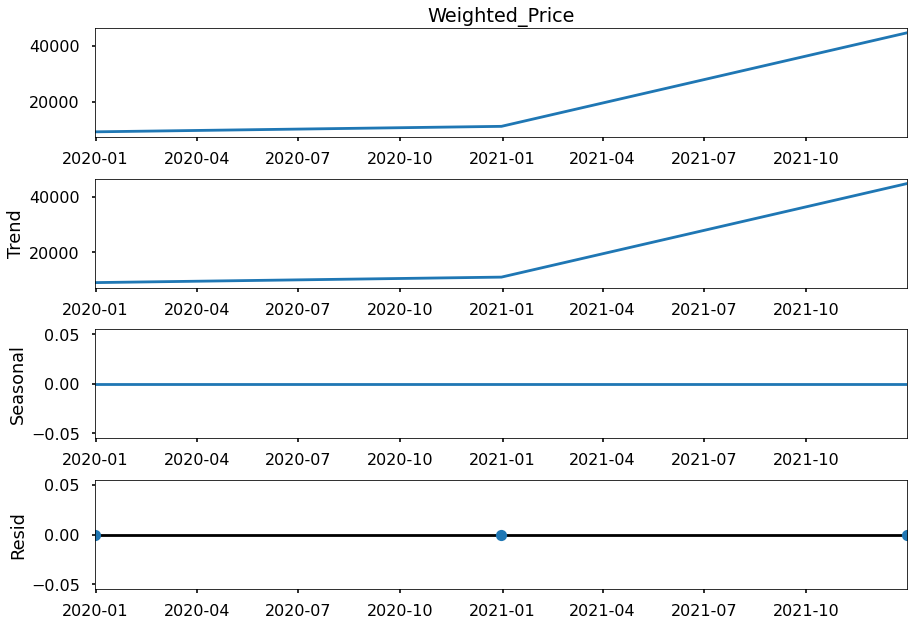

In [16]:
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_year.Weighted_Price).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_year.Weighted_Price)[1])
plt.show()

## Feature Engineering
A continuación vamos a generar distintos indicadores para enriquecer el conjunto de datos

In [17]:
df = bitcoin
# Filter by relevant attributes
original_att = [
    'Timestamp',
        'Target',
    'Close_previous',
    'Date',
    'Year',
    'Month',
    'Week',
    'Weekday',
    'Day',
    'Hour',
    'Timestamp',
    'Open',
    'High',
    'Low',
    'Close',
    'Volume_BTC',
    'Volume_USD',
    'Weighted_Price'
]
relevant_att = [
    'Open',
    'High',
    'Low',
    'Close',
    'Volume_BTC',
    'Volume_USD',
    'Weighted_Price',
    'volume_adi',
    'volume_obv',
    'volume_cmf',
    'volume_fi',
    'volume_vpt',
    'volume_vwap',
    'volatility_kcc',
    'volatility_kch',
    'volatility_kcl',
    'volatility_kcw',
    'volatility_kcp',
    'volatility_kchi',
    'volatility_kcli',
    'volatility_atr',
    'volatility_ui',
    'trend_macd',
    'trend_macd_signal',
    'trend_macd_diff',
    'trend_sma_fast',
    'trend_sma_slow',
    'trend_ema_fast',
    'trend_ema_slow',
    'trend_kst',
    'trend_kst_sig',
    'trend_kst_diff',
    'trend_ichimoku_conv',
    'trend_ichimoku_base',
    'trend_ichimoku_a',
    'trend_ichimoku_b',
    'trend_adx',
    'trend_adx_pos',
    'trend_adx_neg',
    'trend_cci',
    'momentum_tsi',
    'momentum_stoch',
    'momentum_stoch_signal',
    'others_dr'
]

In [18]:
# shift
df = addPreviousClose(df)
df = addTargetFeature(df)
df = addDateFeatures(df)
# Clean NaN values
df = addAllFeaturesWithoutNan(df)

In [19]:
df_corr = df[relevant_att]

In [20]:
df_corr_trend = df_corr.loc[:,list(map(lambda x : ('trend' in x) or ((x in original_att) and (x != 'Target')), relevant_att))]
df_corr_volatility = df_corr.loc[:,list(map(lambda x : ('volatility' in x) or ((x in original_att) and (x != 'Target')), relevant_att))]
df_corr_volume = df_corr.loc[:,list(map(lambda x : ('volume' in x) or ((x in original_att) and (x != 'Target')), relevant_att))]
df_corr_momentum = df_corr.loc[:,list(map(lambda x : ('momentum' in x) or ((x in original_att) and (x != 'Target')), relevant_att))]

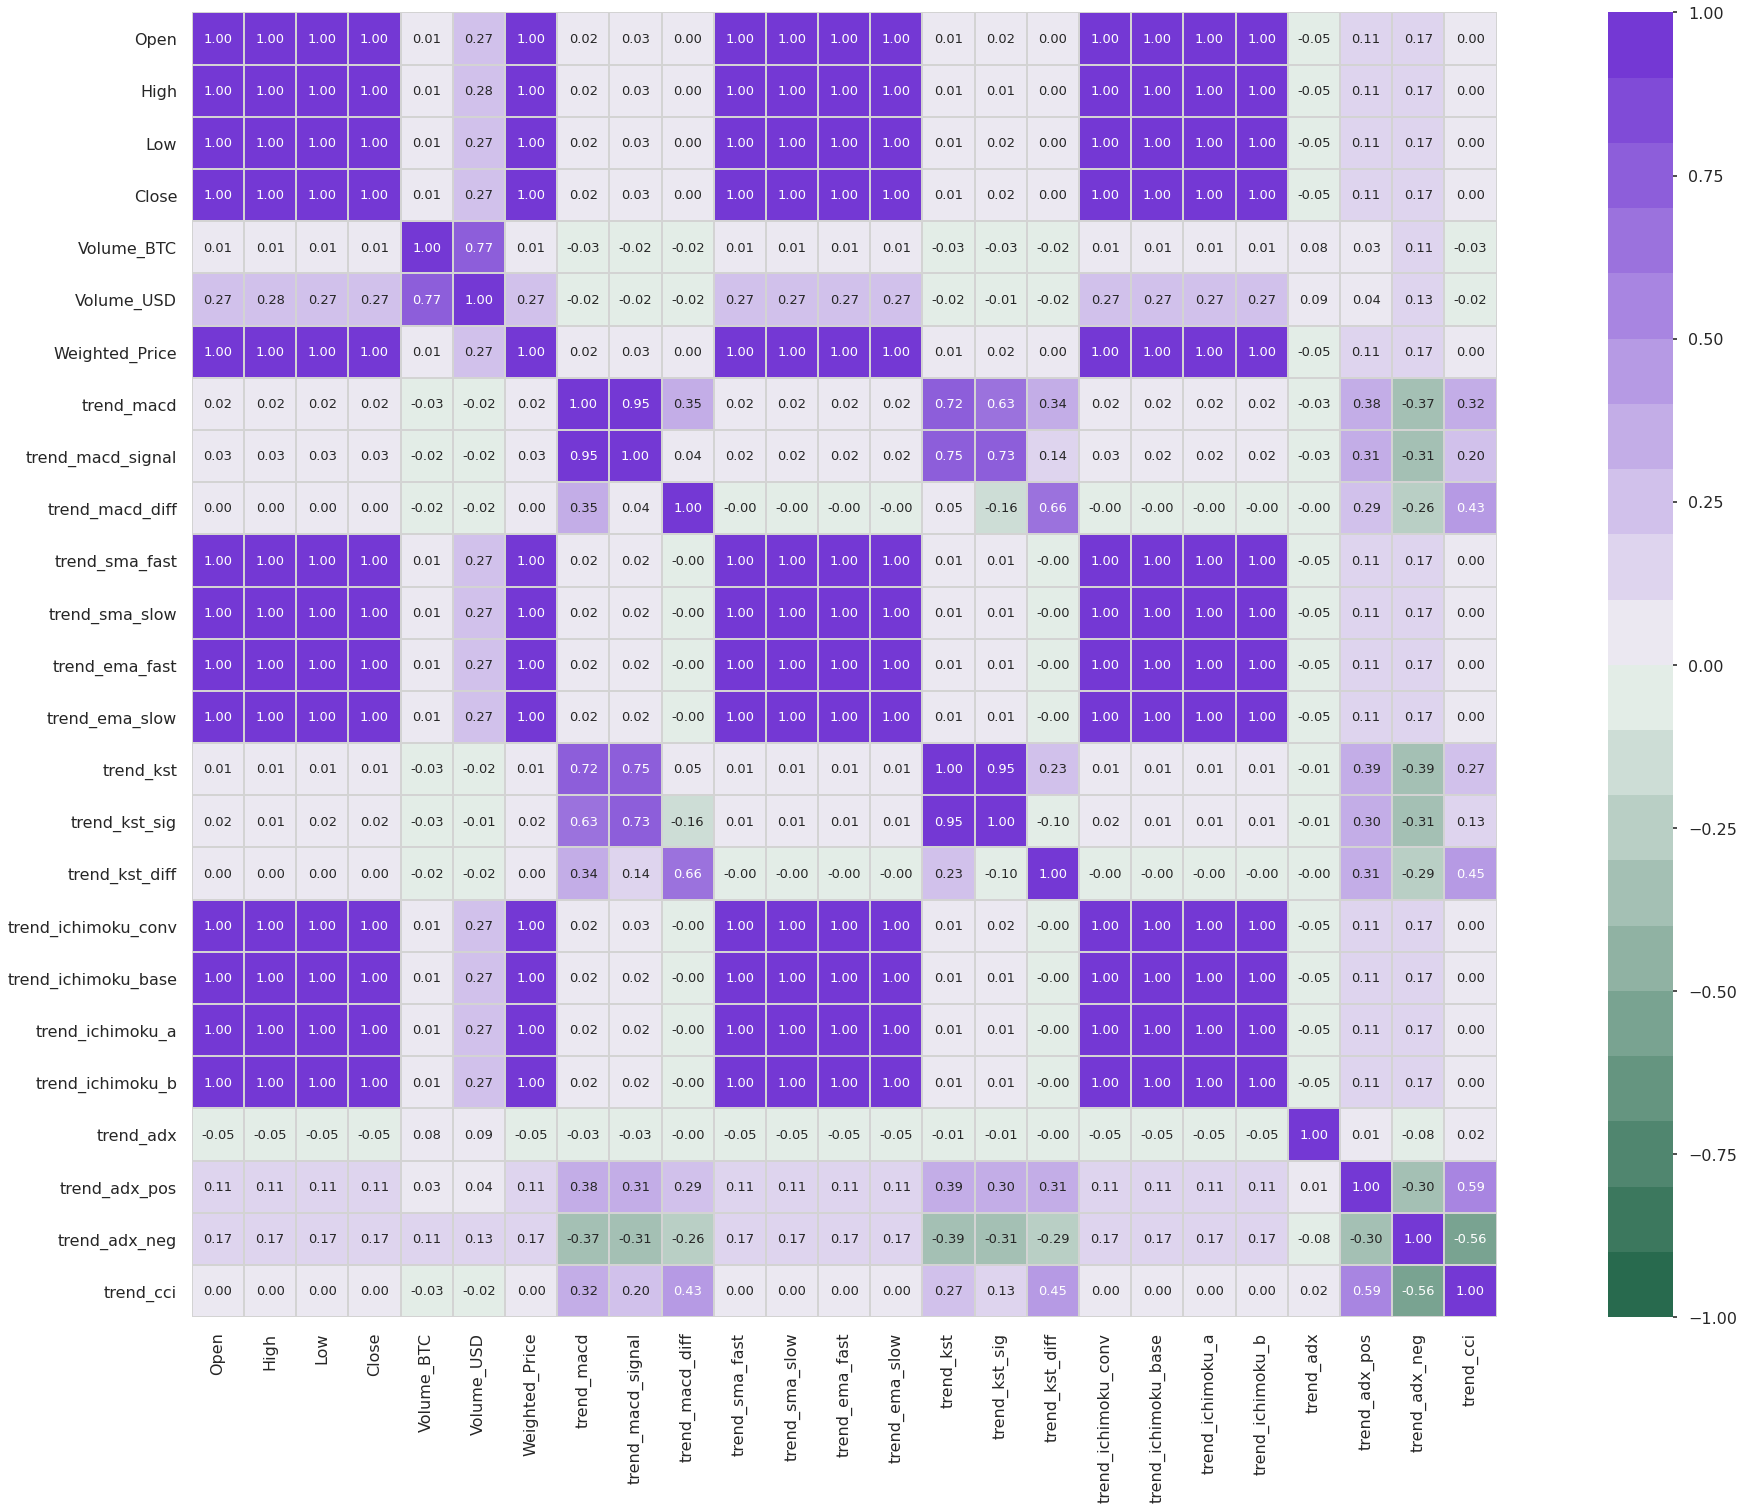

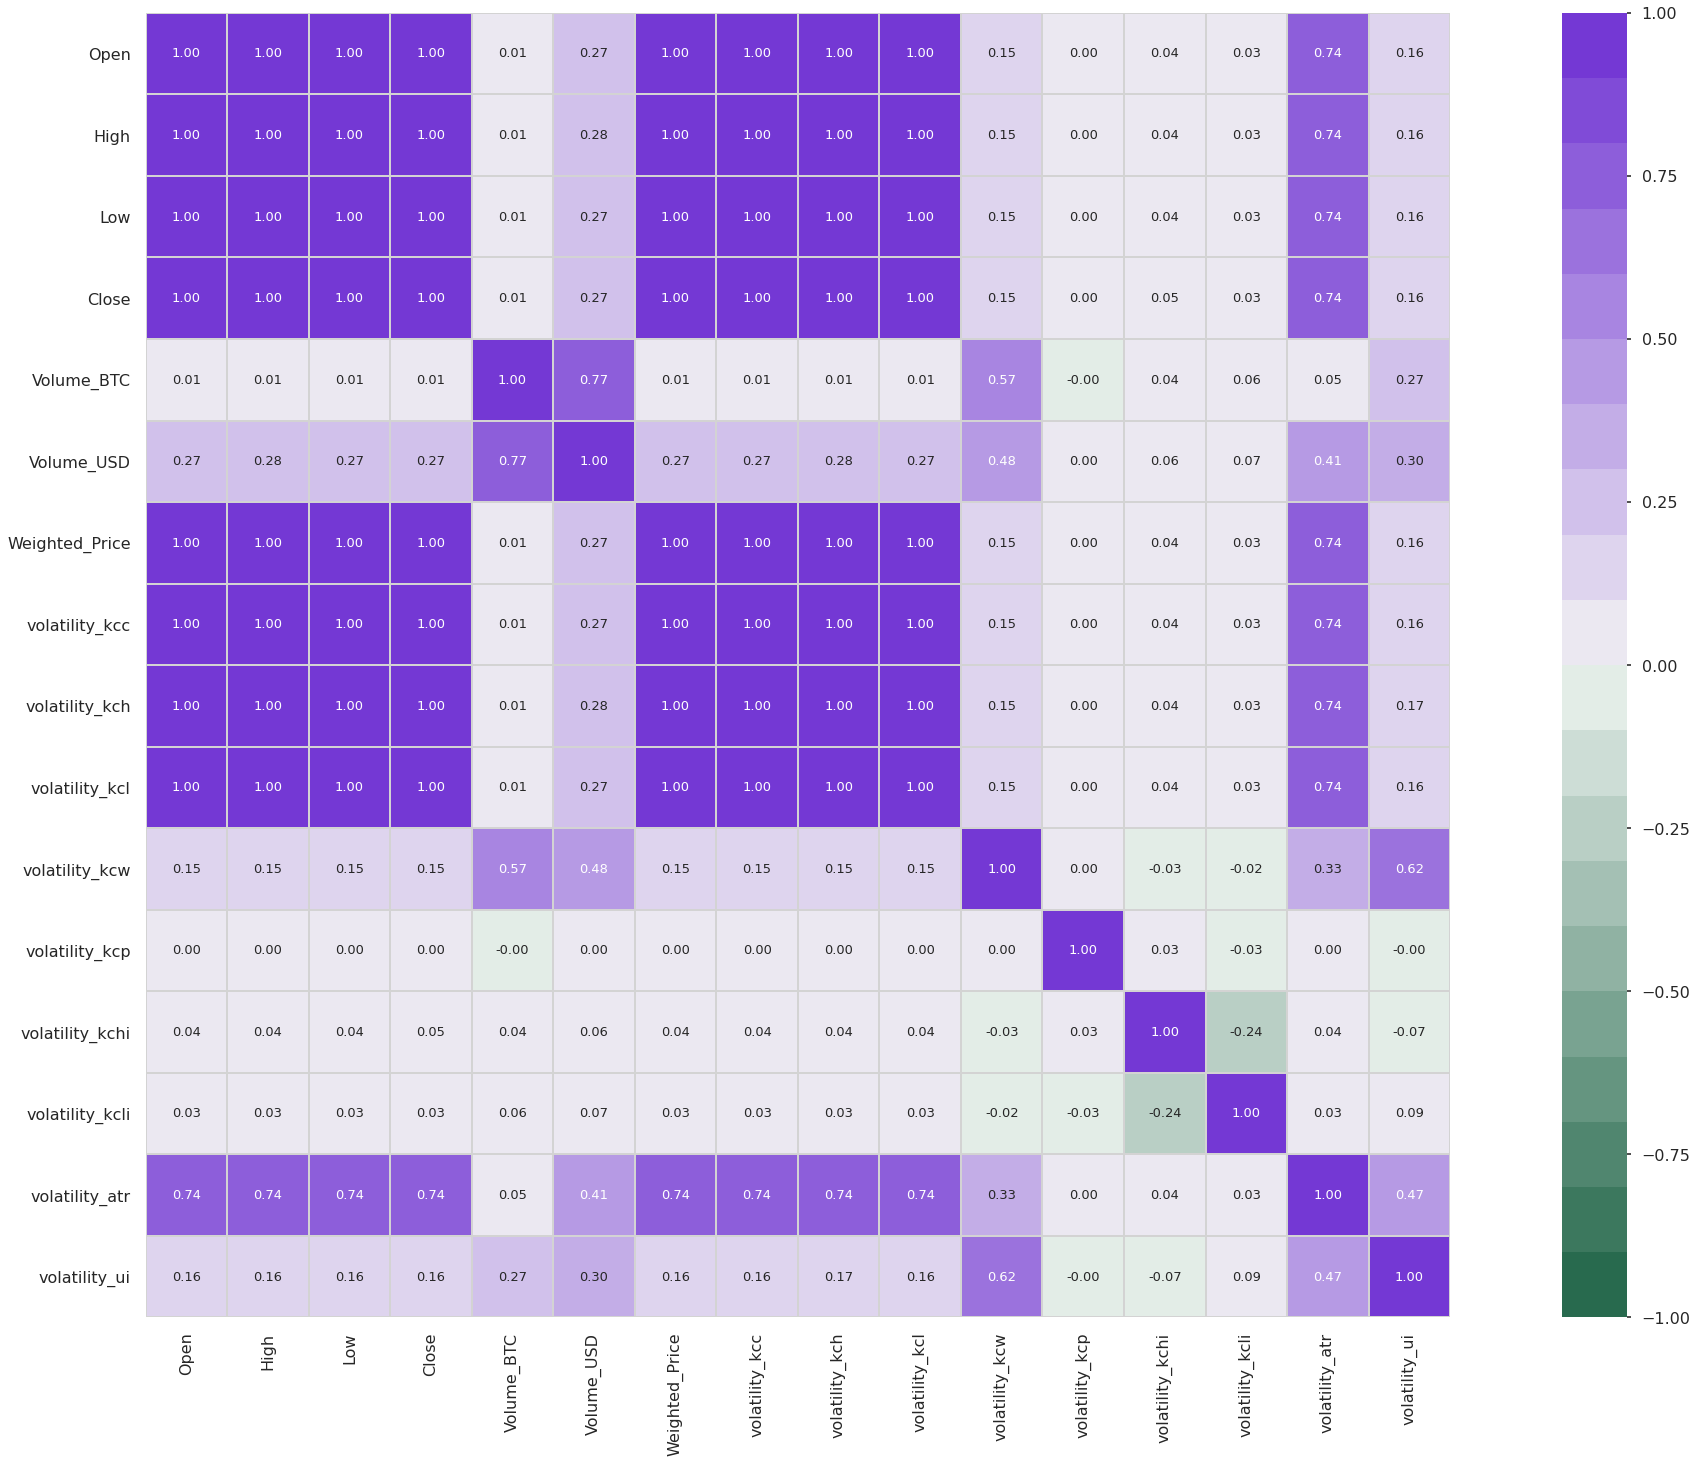

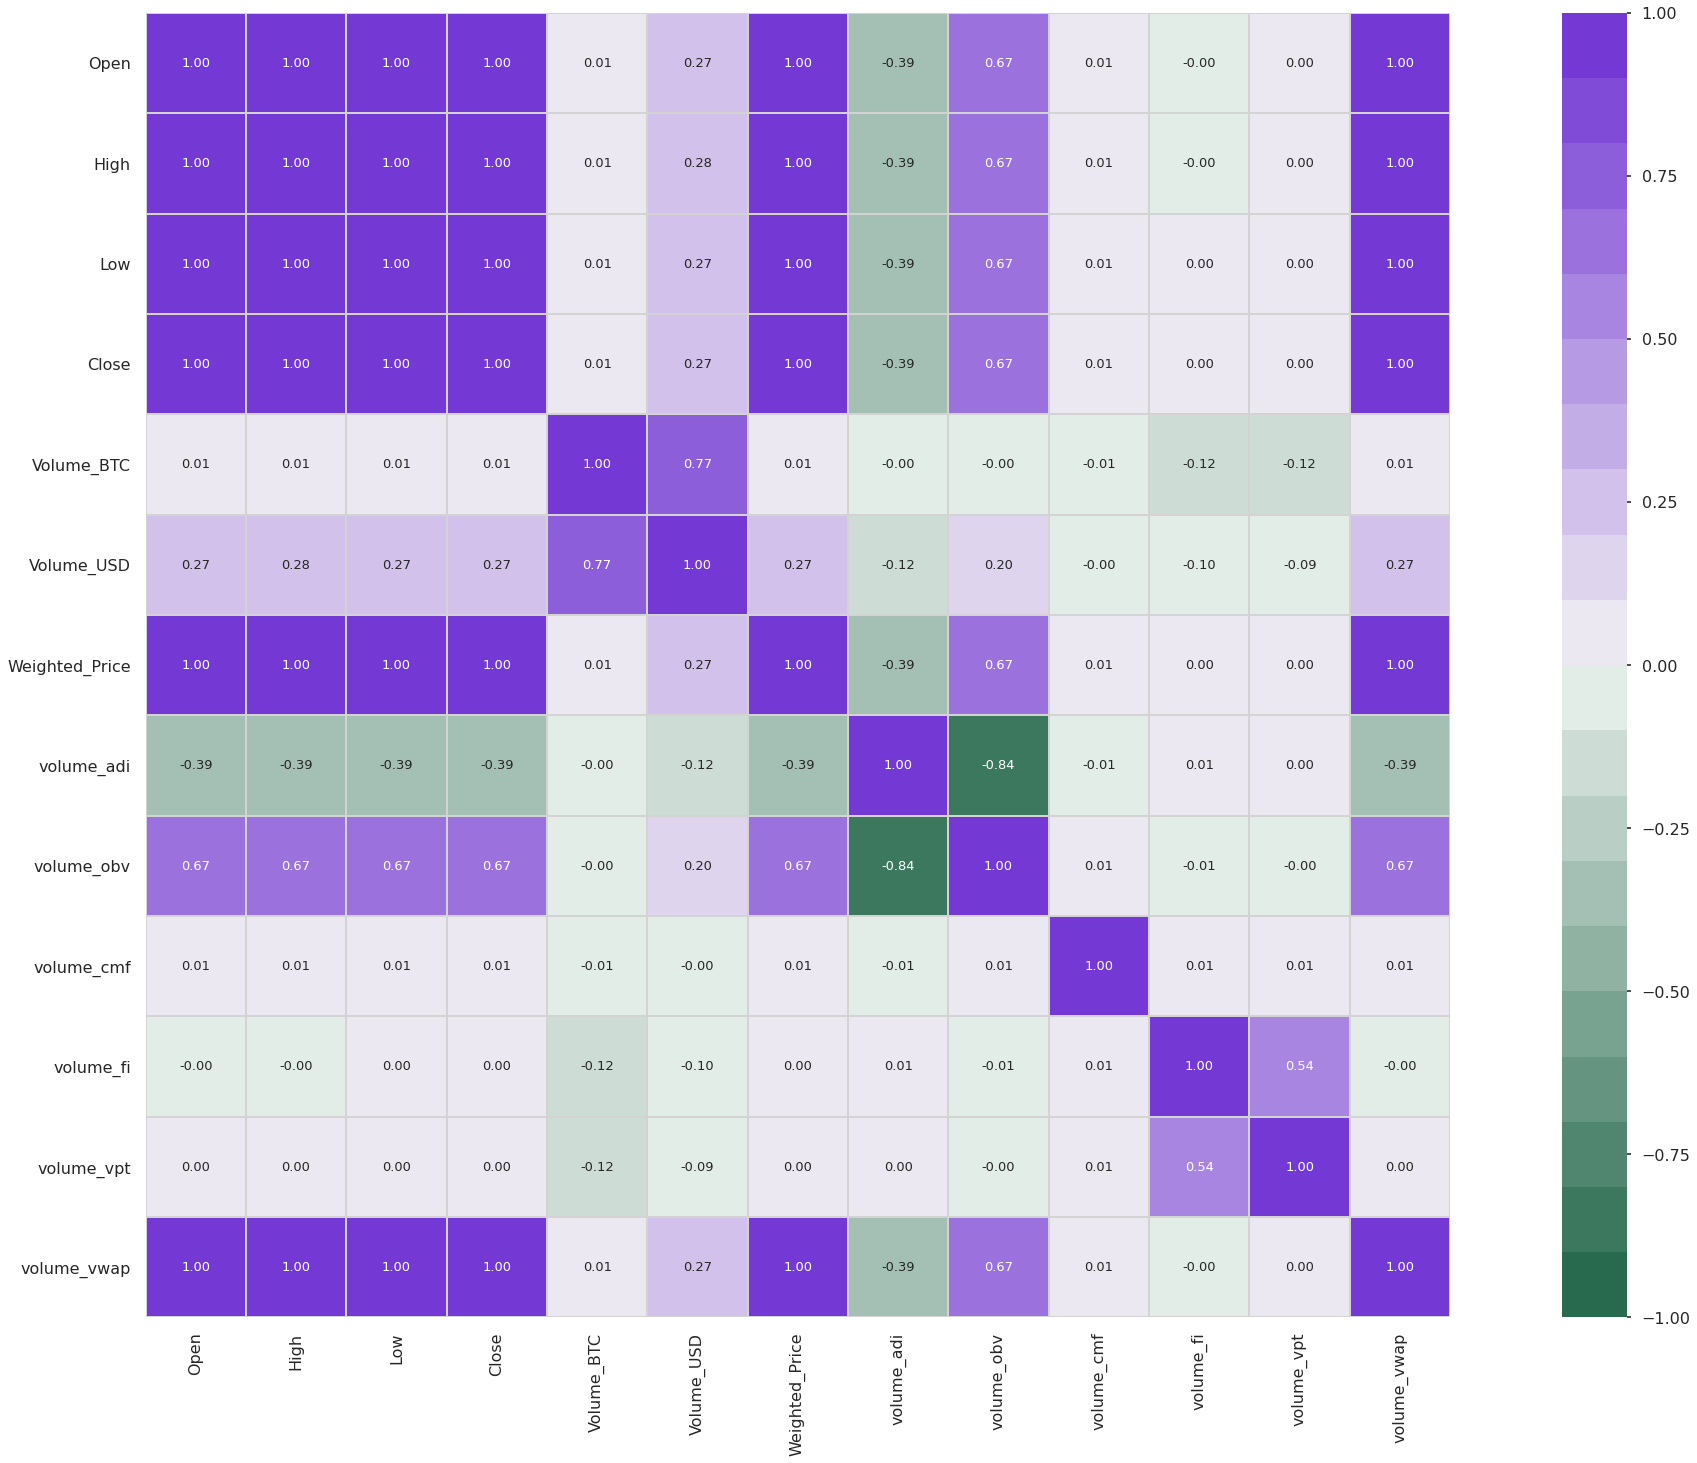

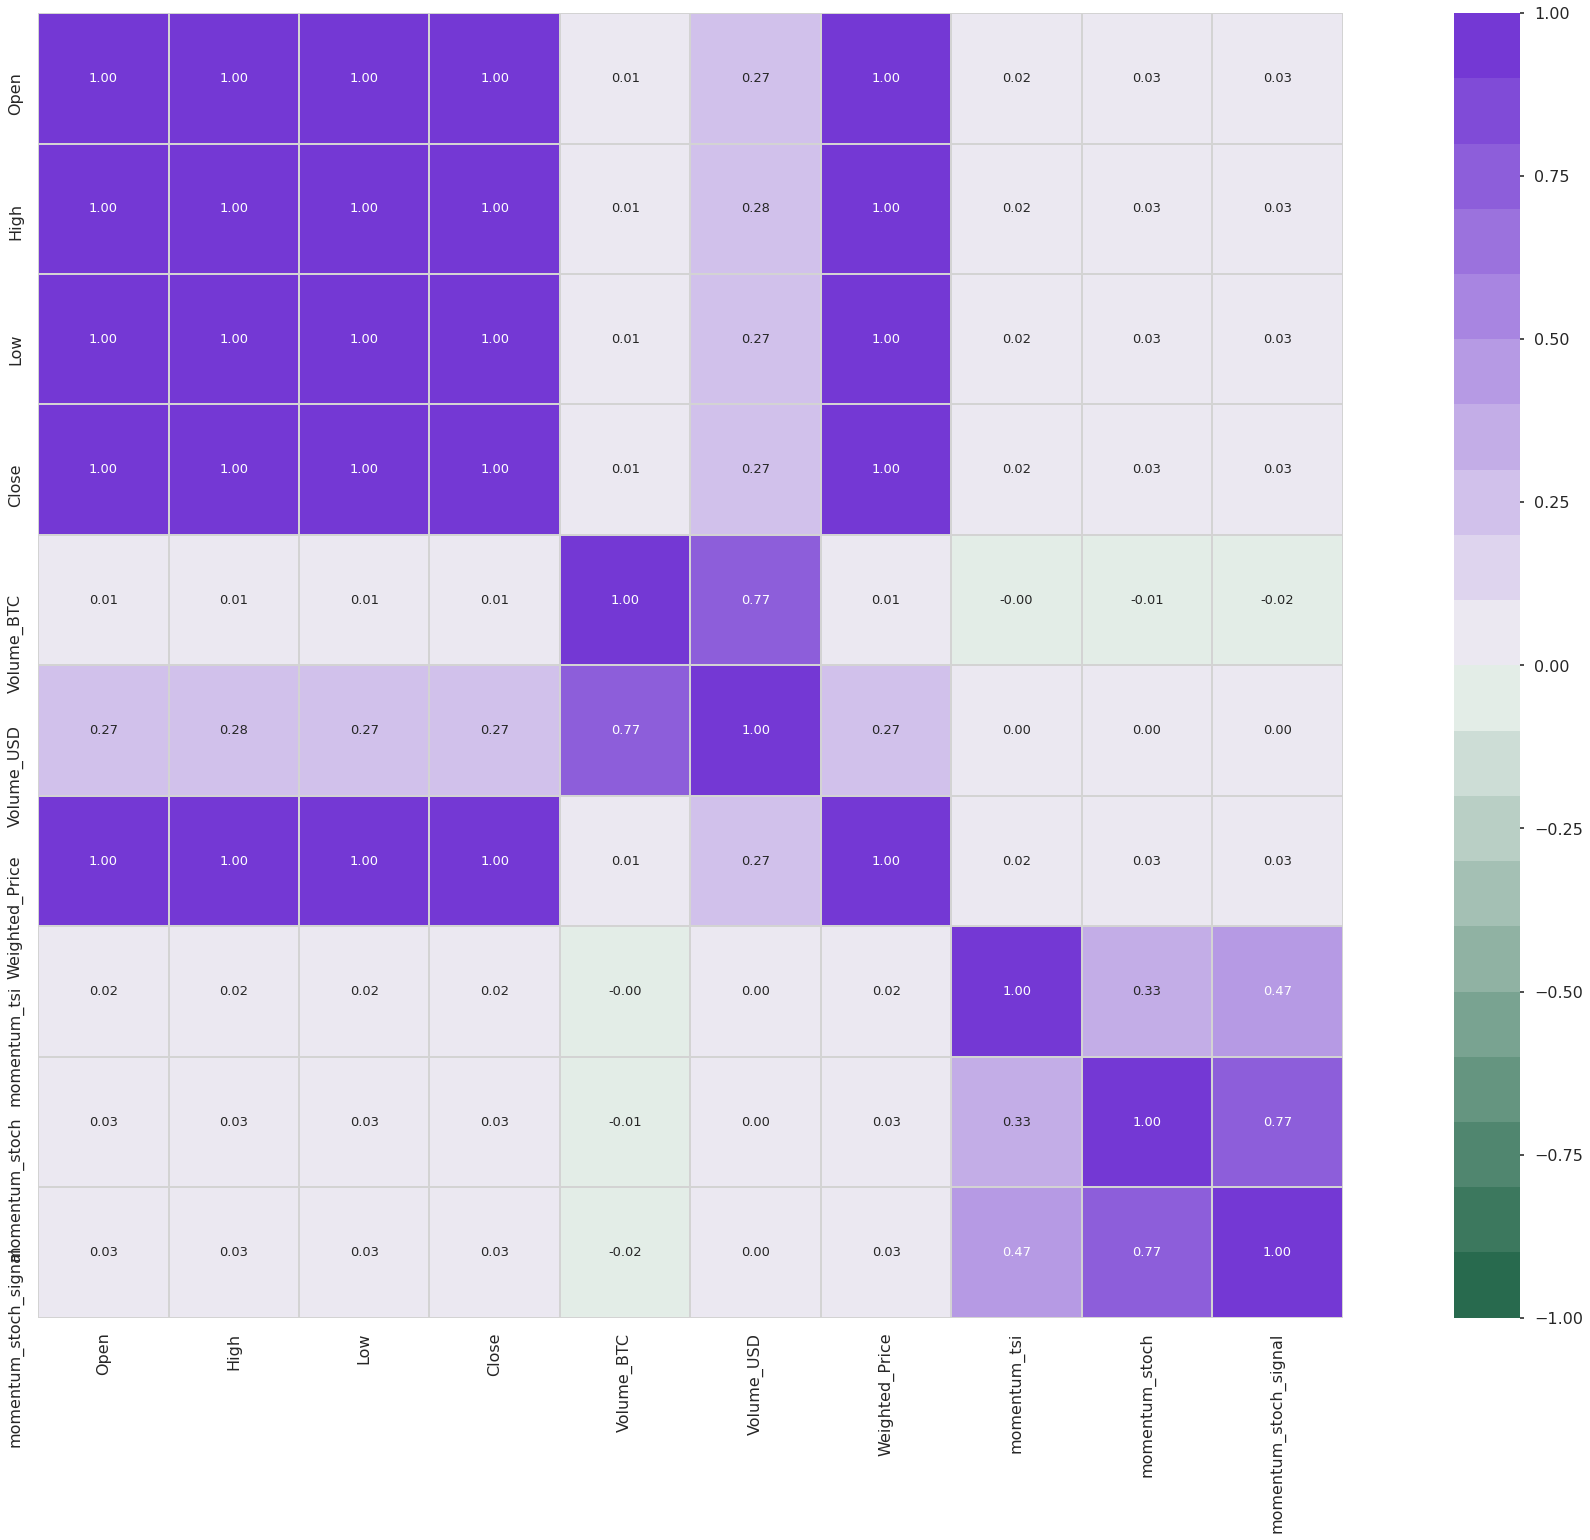

In [21]:
correlationMatrix(df_corr_trend, (40,24))
correlationMatrix(df_corr_volatility, (40,24))
correlationMatrix(df_corr_volume, (40,24))
correlationMatrix(df_corr_momentum, (40,24))

### Filter attributes by correlation

In [22]:
no_corr_att = [
    'Close',
    'Volume_BTC',
    'Volume_USD',
    'volume_adi',
    'volume_cmf',
    'volume_fi',
    'volume_vpt',
    'volatility_kcw',
    'volatility_kchi',
    'volatility_ui',
    'trend_kst_sig',
    'trend_kst_diff',
    'trend_adx',
    'momentum_stoch_signal',
    'others_dr'
]

In [23]:
df_corr = df[no_corr_att]

In [87]:
df_week= df_week[no_corr_att]
df_day= df_day[no_corr_att]
df_month= df_day[no_corr_att]
df_year= df_day[no_corr_att]
df_Q= df_day[no_corr_att]

KeyError: "['volume_adi', 'volume_cmf', 'volume_fi', 'volume_vpt', 'volume_vwap', 'volatility_kcw', 'volatility_kchi', 'volatility_ui', 'trend_sma_slow', 'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_b', 'trend_adx', 'momentum_stoch_signal', 'others_dr'] not in index"

In [24]:
df_corr_trend = df_corr.loc[:,list(map(lambda x : ('trend' in x) or ((x in original_att) and (x != 'Target')), no_corr_att))]
df_corr_volatility = df_corr.loc[:,list(map(lambda x : ('volatility' in x) or ((x in original_att) and (x != 'Target')), no_corr_att))]
df_corr_volume = df_corr.loc[:,list(map(lambda x : ('volume' in x) or ((x in original_att) and (x != 'Target')), no_corr_att))]
df_corr_momentum = df_corr.loc[:,list(map(lambda x : ('momentum' in x) or ((x in original_att) and (x != 'Target')), no_corr_att))]

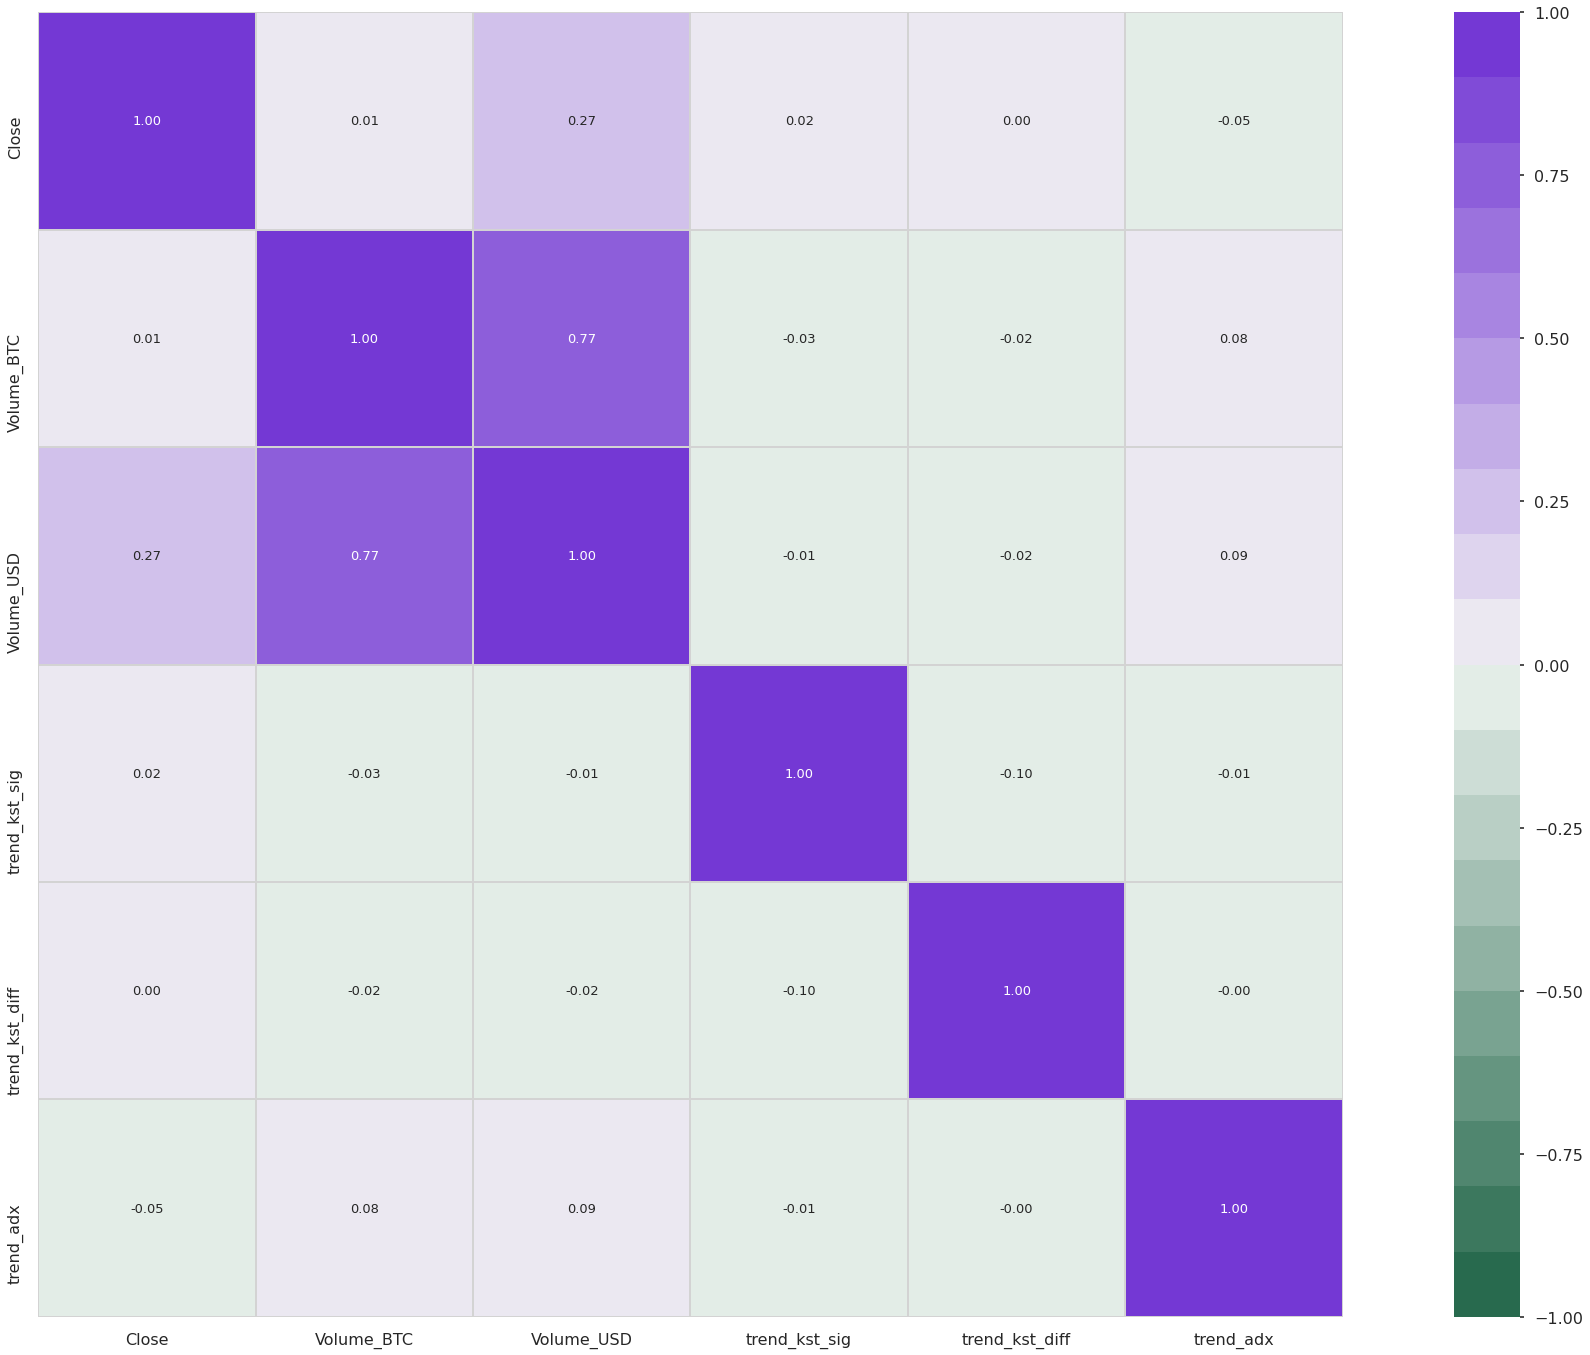

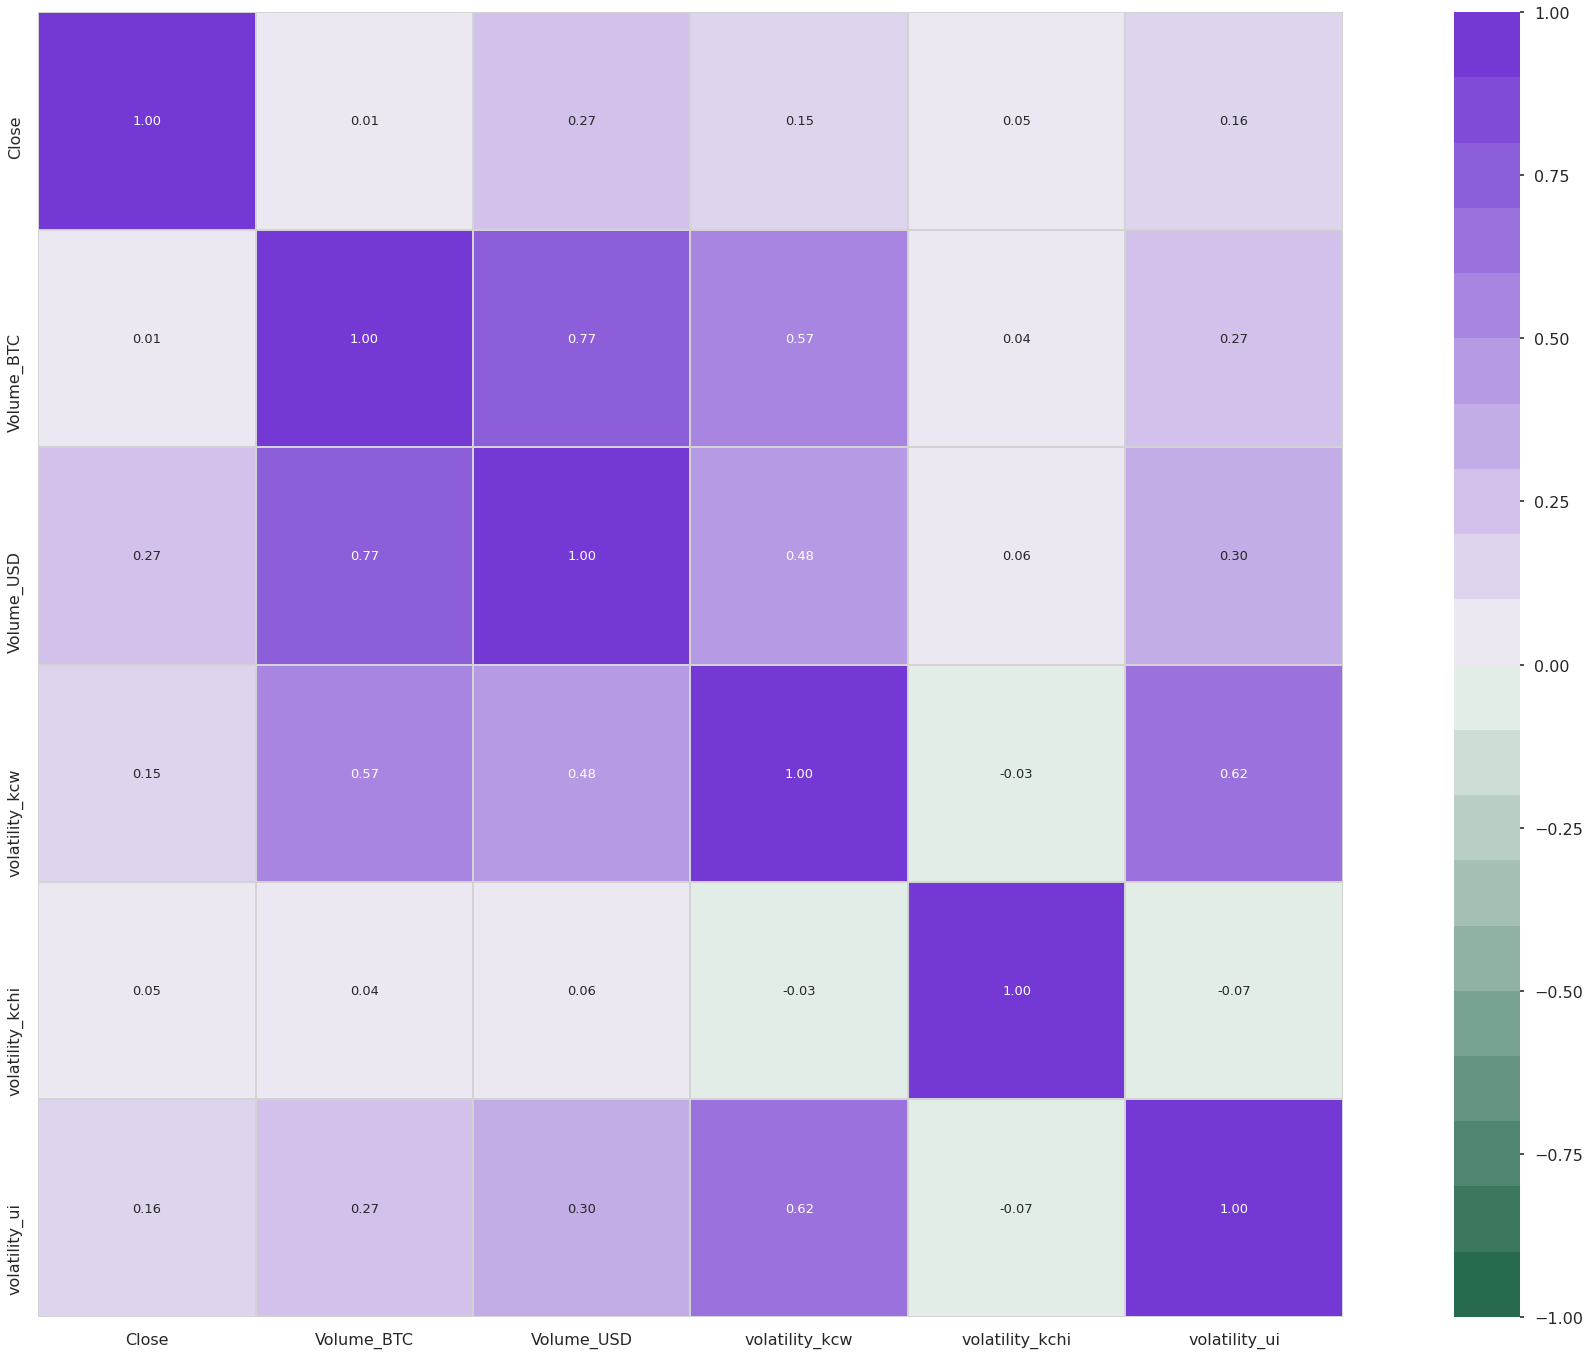

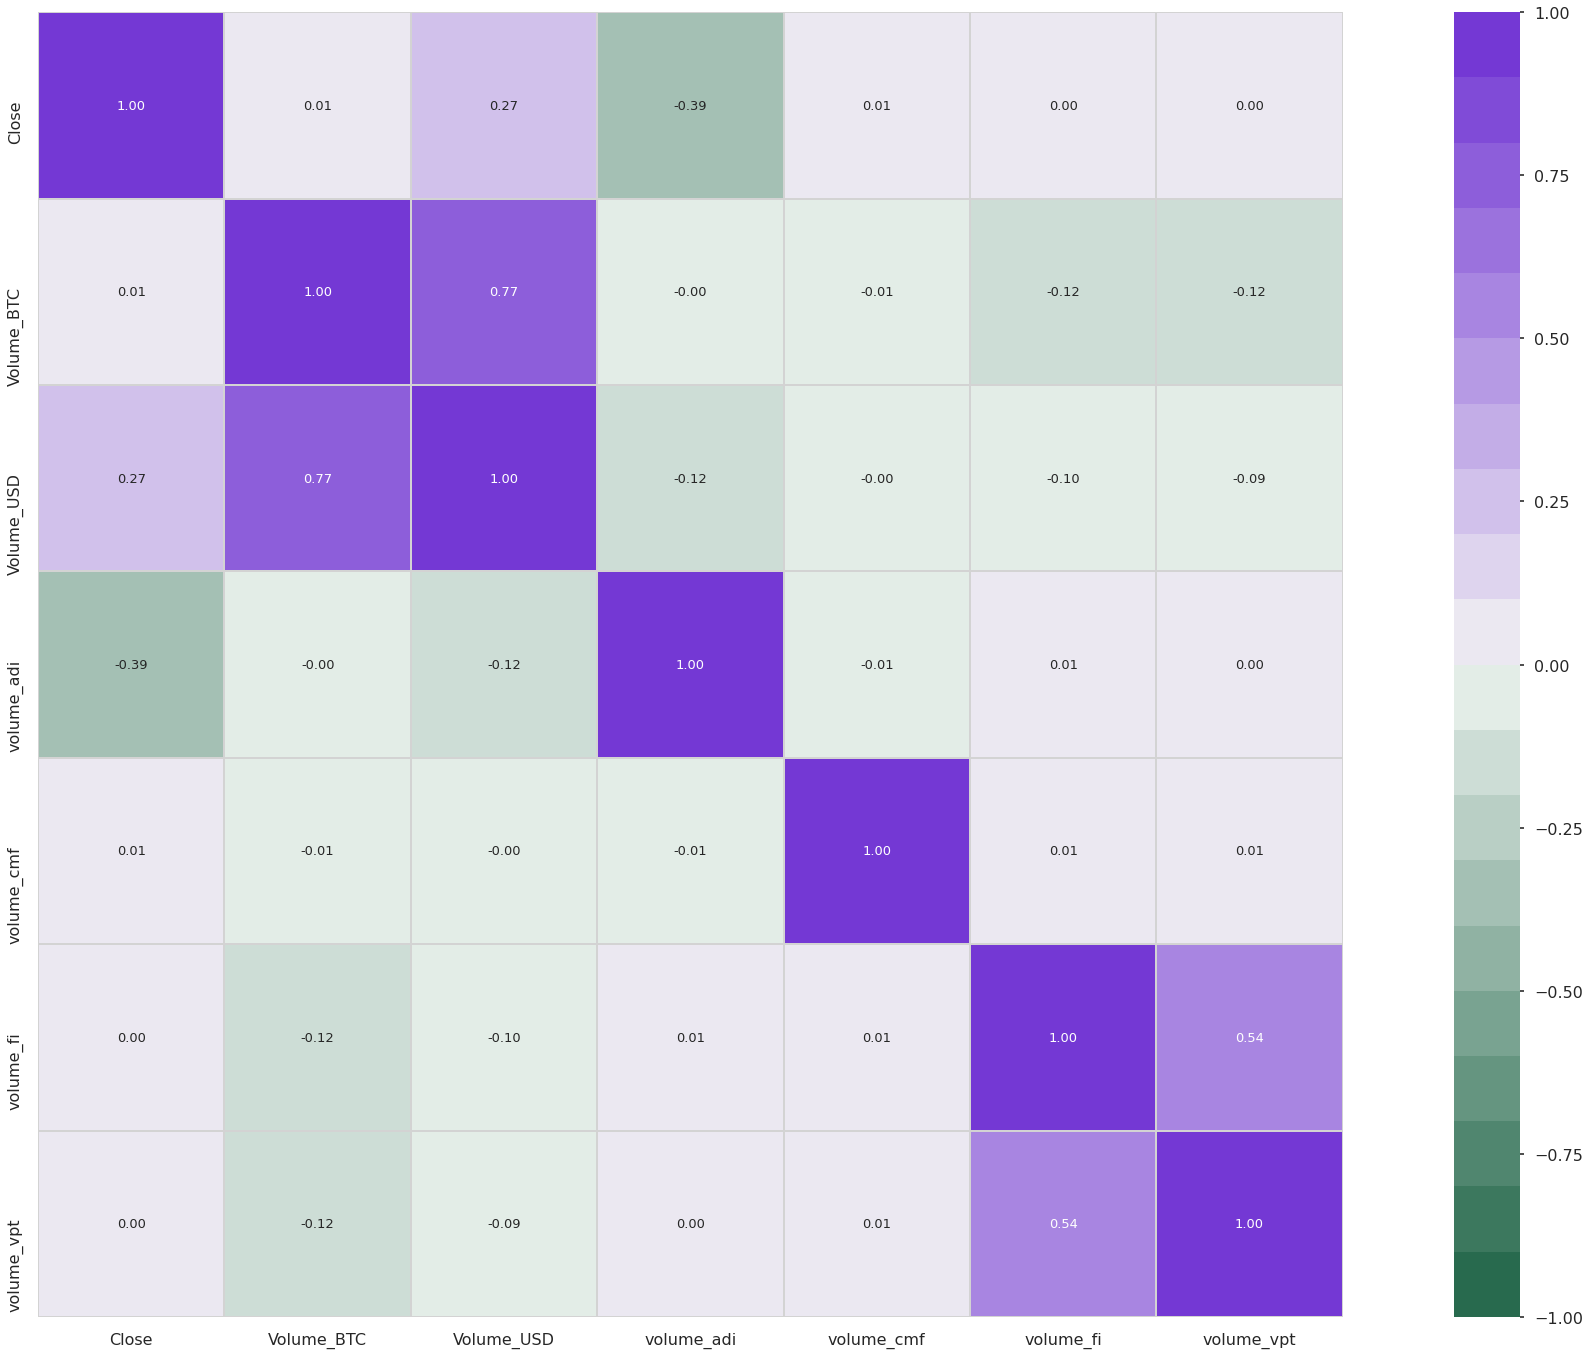

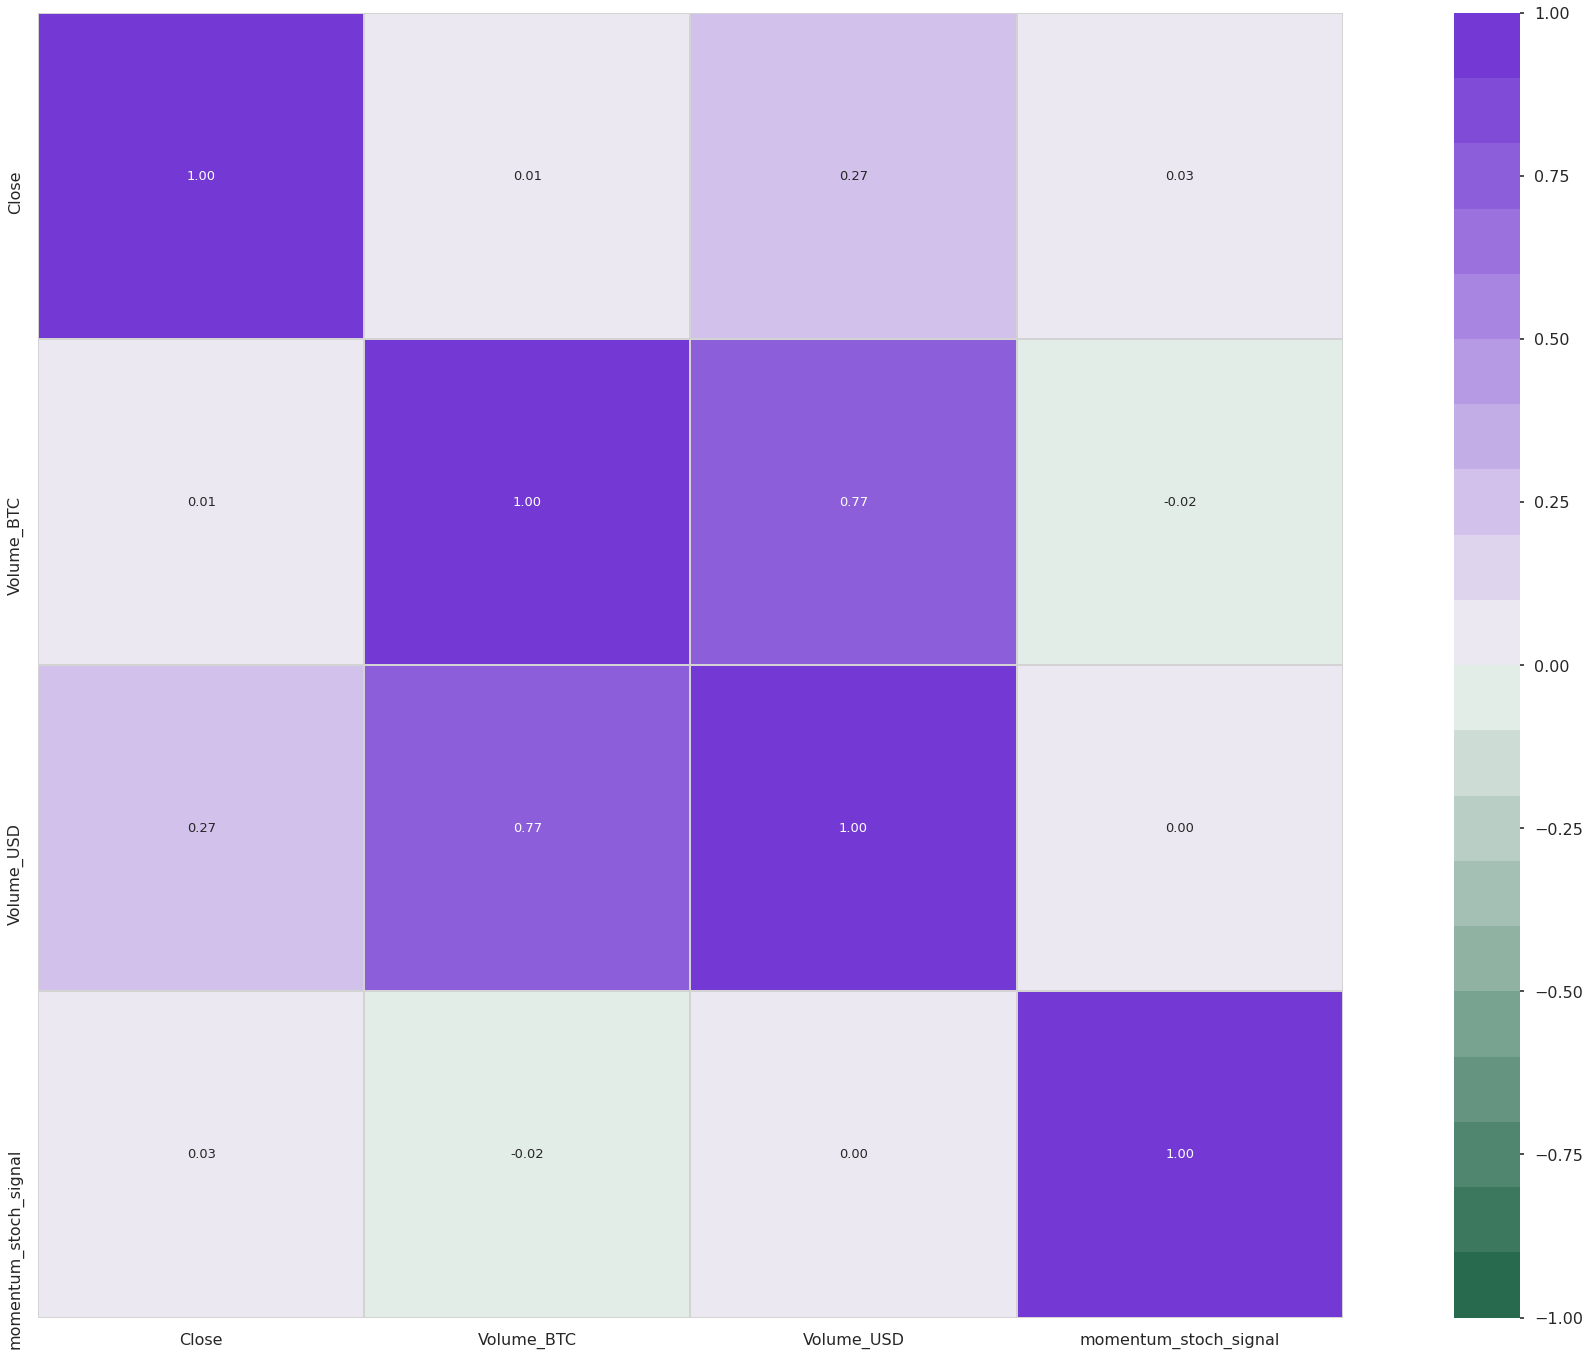

In [25]:
correlationMatrix(df_corr_trend, (40,24))
correlationMatrix(df_corr_volatility, (40,24))
correlationMatrix(df_corr_volume, (40,24))
correlationMatrix(df_corr_momentum, (40,24))

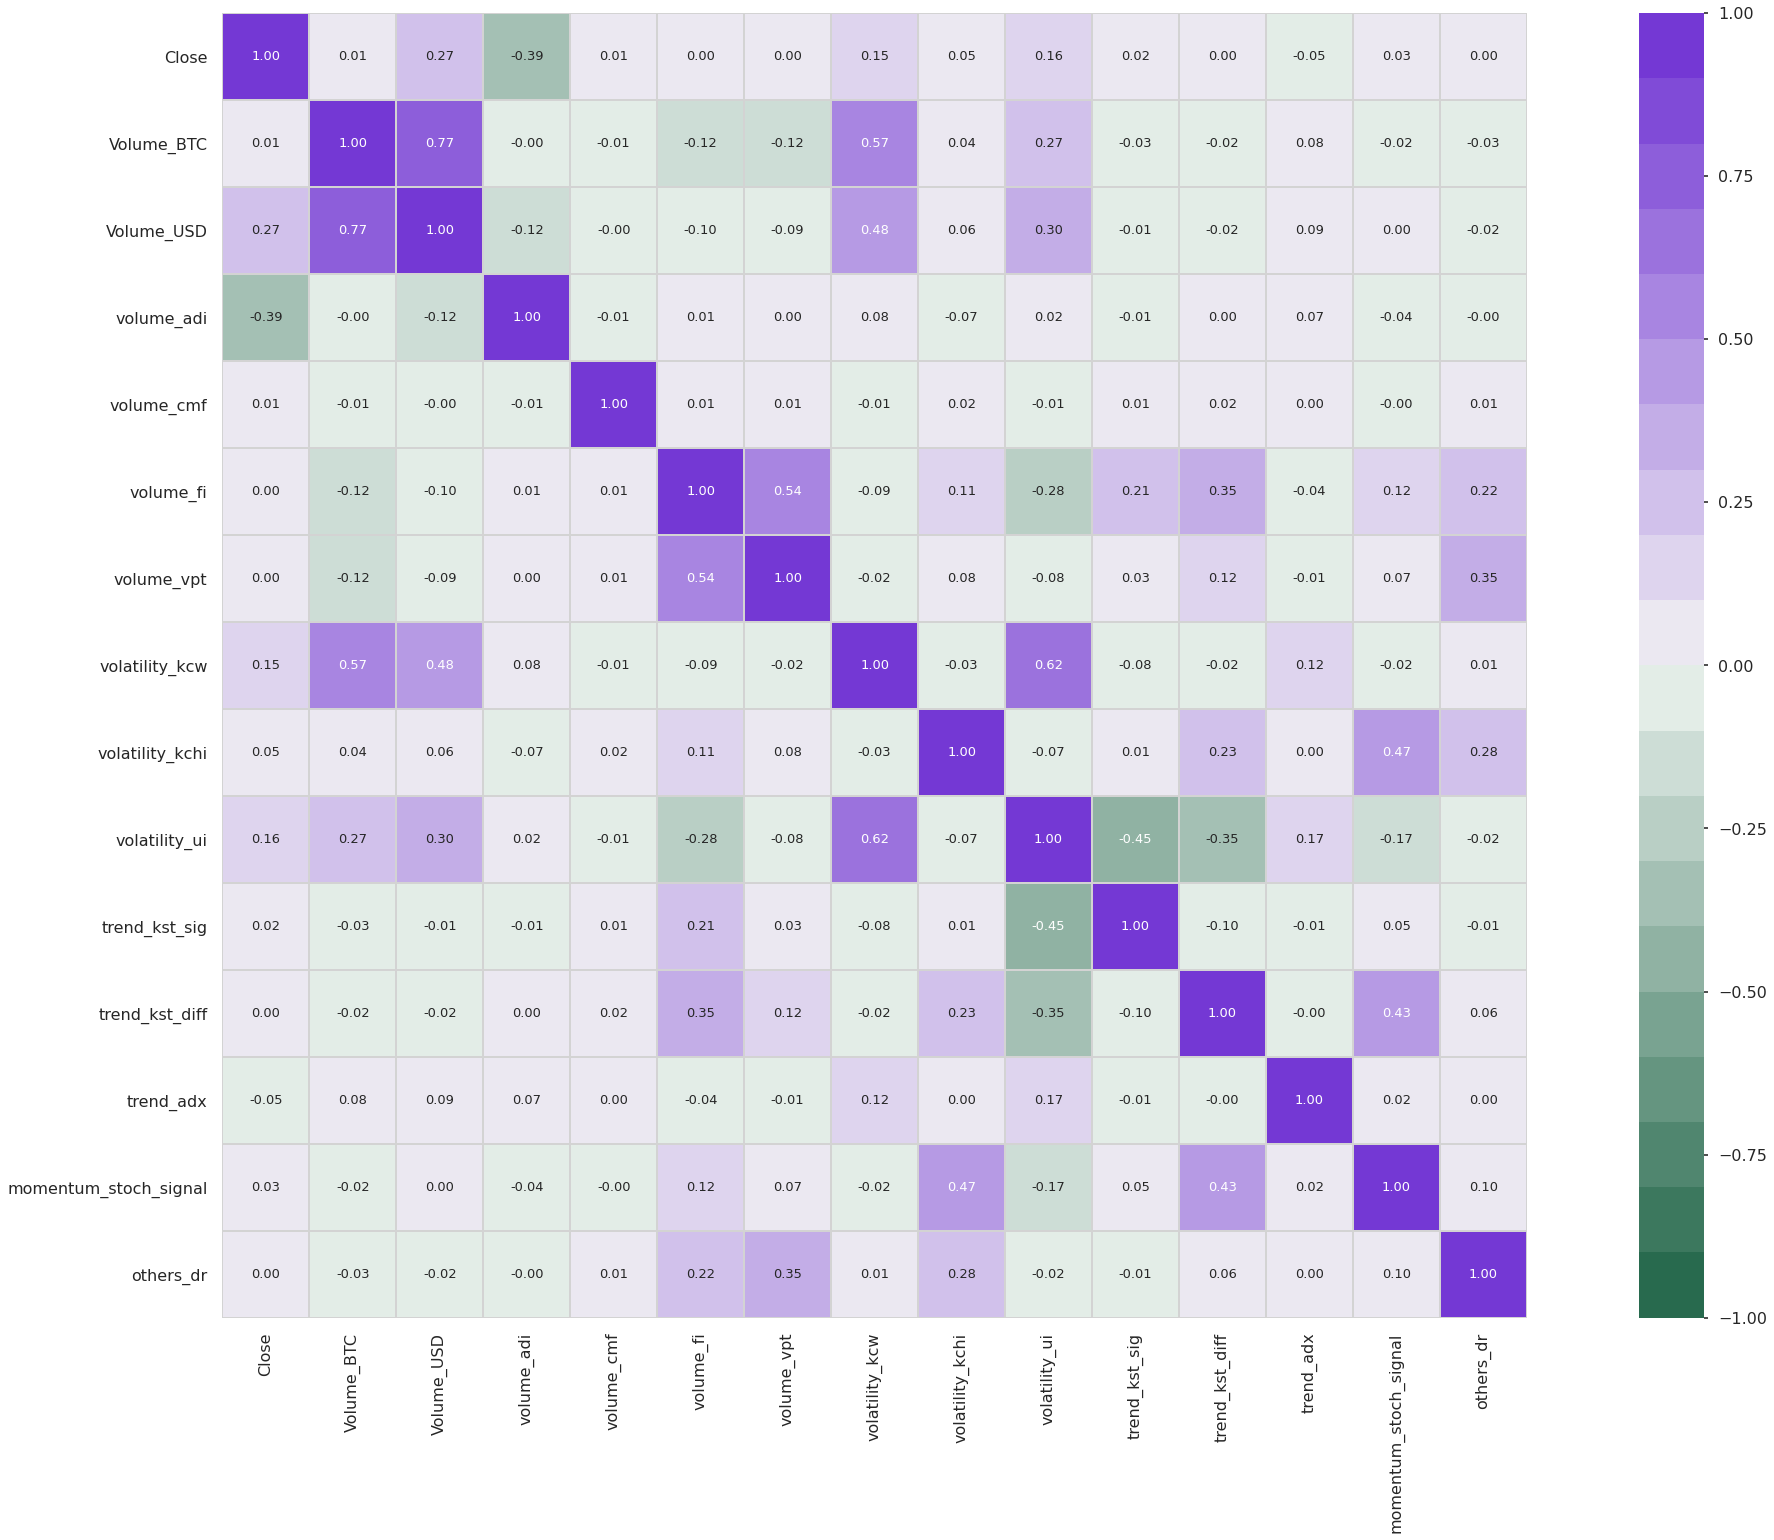

In [26]:
correlationMatrix(df_corr, (40,24))

In [28]:
df_corr.to_csv('processed_data/processed_bitcoin_history.csv')

In [59]:
df_corr.to_csv('processed_data_2/processed_bitcoin_history.csv')
df_week.to_csv('processed_data_2/processed_bitcoin_history_week.csv')
df_day.to_csv('processed_data_2/processed_bitcoin_history_day.csv')
df_month.to_csv('processed_data_2/processed_bitcoin_history_month.csv')
df_year.to_csv('processed_data_2/processed_bitcoin_history_year.csv')
df_Q.to_csv('processed_data_2/processed_bitcoin_history_Q.csv')

In [44]:
df_corr = scaleDataFrame(df_corr)
df_week = scaleDataFrame(df_week)
df_day =  scaleDataFrame(df_day)
df_month =  scaleDataFrame(df_month)
df_year =  scaleDataFrame(df_year)
df_Q =  scaleDataFrame(df_Q)

### Atributos
- volume_adi: [Acumulation Distribution indicator](https://www.investopedia.com/terms/a/accumulationdistribution.asp)
- volume_mfi: Money flow index
- volume_obv: [On-Balance-Volume](https://www.investopedia.com/terms/o/onbalancevolume.asp) 
- volume_cmf: [Chaikin Money Flow](https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/cmf)
- volume_fi: [Force index](https://en.wikipedia.org/wiki/Force_index)
- volume_vpt:[Volume-price Trend]
- volume_vwap:[Volume Weighted Average Price] 



# Split train - test (XGBoost, esto podria ir aparte)

In [145]:
df = df_corr

In [107]:
train, test = utils.split_df2(df)
excl = ['Close_target', 'Target', 'Date', 'Timestamp']
cols = [c for c in df.columns if c not in excl]

In [108]:
y_train = train['Target']
y_mean = np.mean(y_train)
xgb_params = {
    'n_trees': 800,
    'eta': 0.0045,
    'max_depth': 20,
    'subsample': 1,
    'colsample_bytree': 0.95,
    'colsample_bylevel': 0.95,
    'objective': 'multi:softmax',
    'num_class' : 3,
    'eval_metric': 'mlogloss', # 'merror', # 'rmse',
    'base_score': 0,
    'silent': 1
}

dtrain = xgb.DMatrix(train[cols], y_train)
dtest = xgb.DMatrix(test[cols])

cv_result = xgb.cv(xgb_params, dtrain)

# xgboost, cross-validation
"""
cv_result = xgb.cv(xgb_params,
                   dtrain,
                   num_boost_round=5000,
                   early_stopping_rounds=50,
                   verbose_eval=50,
                   show_stdv=False
                  )
num_boost_rounds = len(cv_result)
"""
num_boost_rounds = 705

print(num_boost_rounds)

# train
model = xgb.train(xgb_params, dtrain, num_boost_round=num_boost_rounds)

# predict
y_pred = model.predict(dtest)
y_true = test['Target']

utils.metrics(y_true, y_pred)

print("\n \n \n \n \n \n ********** WEIGHT ************")
importance = model.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))
for i in importance:
    print (i)
    
print("\n \n \n \n \n \n ********** GAIN ************")
importance = model.get_score(fmap='', importance_type='gain')
importance = sorted(importance.items(), key=operator.itemgetter(1))
for i in importance:
    print (i)
    
print("\n \n \n \n \n \n ********** COVER ************")
importance = model.get_score(fmap='', importance_type='cover')
importance = sorted(importance.items(), key=operator.itemgetter(1))
for i in importance:
    print (i)



[20:11:52] WARNING: ../src/learner.cc:627: 
Parameters: { "n_trees", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:11:52] WARNING: ../src/learner.cc:627: 
Parameters: { "n_trees", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:11:52] WARNING: ../src/learner.cc:627: 
Parameters: { "n_trees", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter act

ValueError: Number of classes, 2, does not match size of target_names, 3. Try specifying the labels parameter